# Libraries

In [184]:
!pip install ipynb
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score, silhouette_score
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.cluster import KMeans

from ipynb.fs.full.my_functions import *
from sklearn.feature_selection import VarianceThreshold


# Loading the DataSet

https://www.kaggle.com/hb20007/gender-classification

In [185]:
gender = pd.read_csv("Transformed Data Set - Sheet1.csv")
balanced_dataset= gender.copy()
balanced_dataset.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


# Inspecting the Data

In [186]:
M=(balanced_dataset['Gender'].value_counts()['M'])/(len(balanced_dataset))*100
print('percentage of gender Male: ',M)
F=balanced_dataset['Gender'].value_counts()['F']/(len(balanced_dataset))*100
print('percentage of gender Femal: ',F)

percentage of gender Male:  50.0
percentage of gender Femal:  50.0


Initially the dataset is balanced. i.e. The target has equal percentage of both classes,Make and Female.

<AxesSubplot:xlabel='Gender', ylabel='count'>

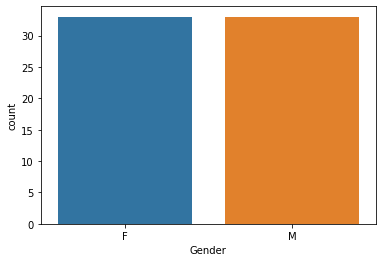

In [187]:
sns.countplot(x="Gender", data=balanced_dataset)

In [188]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Favorite Color        66 non-null     object
 1   Favorite Music Genre  66 non-null     object
 2   Favorite Beverage     66 non-null     object
 3   Favorite Soft Drink   66 non-null     object
 4   Gender                66 non-null     object
dtypes: object(5)
memory usage: 2.7+ KB


There are no numerical features,all the columns contains categorical values.

In [189]:
balanced_dataset.shape

(66, 5)

DataSet has 5 columns and 66 rows.



In [190]:
print('Null Values in the dataset: ',balanced_dataset.isnull().sum().sum())

Null Values in the dataset:  0


No column contains the null values.

In [191]:
print('Duplicates in the dataset: ', balanced_dataset.duplicated().sum())

Duplicates in the dataset:  4


There are 4 duplicate rows in the dataset so we have to drop them in the pre-processing step.

# Visualizing the Data

Displaying the distribution of features among both classes in terms of percentage.
https://medium.com/swlh/how-to-create-percentage-plots-for-visualizing-your-data-in-python-f0d894d7c7bb

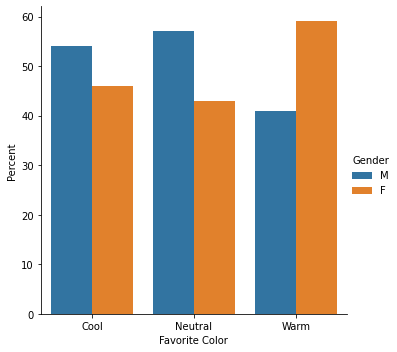

In [192]:
df_temp = balanced_dataset.groupby('Favorite Color')['Gender'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='Favorite Color', y='Percent', hue='Gender', kind='bar', data=df_temp)

Insight from above graph: Percentage of males who like cool and neutral colors is more than females while females prefer warm colors.

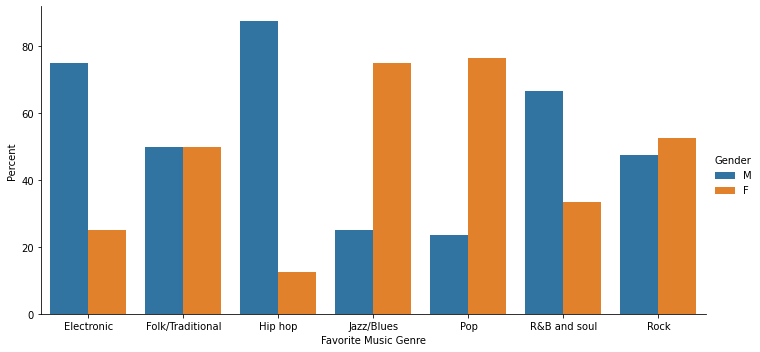

In [193]:
df_temp = balanced_dataset.groupby('Favorite Music Genre')['Gender'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='Favorite Music Genre', y='Percent', hue='Gender', kind='bar', data=df_temp, aspect=2)

Insight: Percentage of male and female liking the music genre folk/traditional is equal. In case of genre rock its also  almost equal, while in case of other genres, percentage differs significantly.

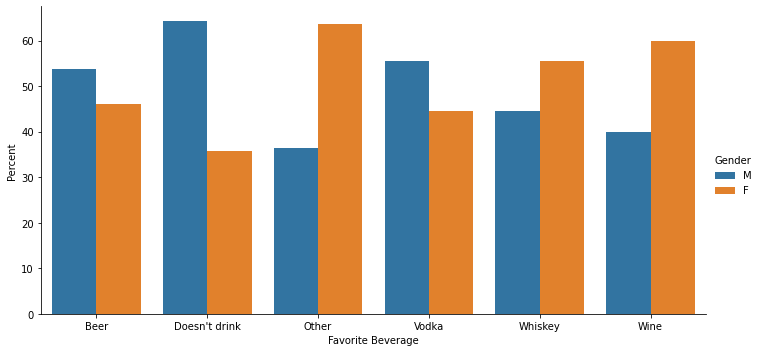

In [194]:
df_temp = balanced_dataset.groupby('Favorite Beverage')['Gender'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='Favorite Beverage', y='Percent', hue='Gender', kind='bar', data=df_temp, aspect=2)

Insight: Percentage of Males who prefer to drink beer and vodka is more than females while females prefer wine, whiskey and other beverages.
Also, percentage of females who drink is more than males.

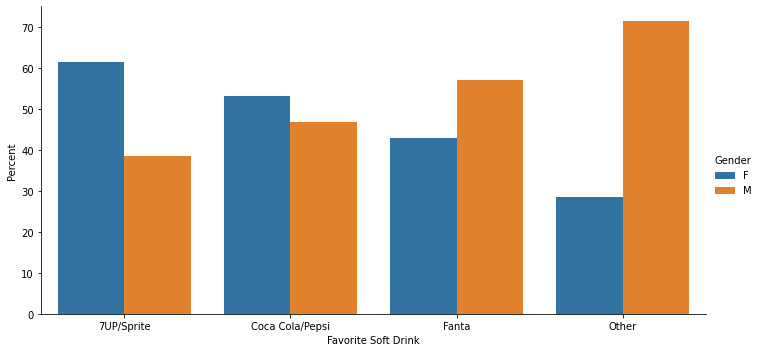

In [195]:
df_temp = balanced_dataset.groupby('Favorite Soft Drink')['Gender'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='Favorite Soft Drink', y='Percent', hue='Gender', kind='bar', data=df_temp, aspect=2)

Insight: 7up/Sprite and Coca Cola/Pepsi are more popluar drinks in females while males prefer fanta and other soft drinks.

# Data pre-processing

In [196]:
print("Number of rows before dropping duplicates: %d" % len(balanced_dataset))
balanced_dataset= balanced_dataset.drop_duplicates()
print("Number of rows after dropping duplicates: %d" % len(balanced_dataset))

Number of rows before dropping duplicates: 66
Number of rows after dropping duplicates: 62


As visualized earlier, they were 4 duplicate rows in the dataset so we have removed them but we need to check if the dataset is still balanced after removing duplicate rows.

In [197]:
M=(balanced_dataset['Gender'].value_counts()['M'])/(len(balanced_dataset))*100
print('percentage of gender Male: ',M)
F=balanced_dataset['Gender'].value_counts()['F']/(len(balanced_dataset))*100
print('percentage of gender Femal: ',F)

percentage of gender Male:  50.0
percentage of gender Femal:  50.0


Balance was not disturbed after dropping the duplicate rows.

In [198]:
features=['Favorite Color','Favorite Music Genre','Favorite Beverage','Favorite Soft Drink']
balanced_dataset[features].describe()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink
count,62,62,62,62
unique,3,7,6,4
top,Cool,Pop,Doesn't drink,Coca Cola/Pepsi
freq,33,17,14,28


Above table shows the number of unique values in a feature as well as the most frequent value and its frequency.

In [199]:

unique_values=0
for i in range(len(features)):
    unique_values=unique_values+len(balanced_dataset[features[i]].unique())
print('Total Unique Values among all features: ',unique_values)

Total Unique Values among all features:  20


On observing the features, it can be seen that the features contains nominal values. i.e. they cannot be ranked so we cannot perform ordinal encoding.Therefore, we are going to perform the one hot encoding.

In [200]:
X_balanced_dataset = pd.get_dummies(balanced_dataset[features]) # get dummies
X_balanced_dataset.head()

,Favorite Color_Cool,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Electronic,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Beer,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_7UP/Sprite,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other
0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


We will be performing label encoding on the target column to convert the values to numerical form.

In [201]:
Y_balanced_dataset=balanced_dataset['Gender'].copy()
encoder=LabelEncoder()
Y_balanced_dataset=encoder.fit_transform(Y_balanced_dataset)
Y_balanced_dataset
#Male=1, Female=0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We are going to drop one column from each feature beacause while creating dummy variables atleast two columns are corelated. I.e. One variable can predict the values of other variables. This problem is known as dummy variable trap.

In [202]:
X_balanced_dataset.drop(columns=['Favorite Color_Cool','Favorite Music Genre_Electronic','Favorite Beverage_Beer','Favorite Soft Drink_7UP/Sprite'],inplace=True)
X_balanced_dataset.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0
3,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


Now we need to make a copy by concatenating features and labels both into a single dataframe, so that we can use it while creating the surrogates.

In [203]:
balanced_dataset=X_balanced_dataset.copy()
balanced_dataset['Gender']=Y_balanced_dataset.tolist()
X_balanced_dataset=balanced_dataset.drop(columns=['Gender'])
Y_balanced_dataset=balanced_dataset['Gender'].copy()

# Creating a Surrogate achieving low Imbalance

In [204]:
F=balanced_dataset[balanced_dataset['Gender'] == 0] 
F= F.sample(replace=False,  n=16, random_state=1) #minority class female represented by 0
M=balanced_dataset[balanced_dataset['Gender'] == 1] 
M= M.sample(replace=False,  n=30, random_state=1) #majority class male represented by 1
Imbalanced_dataset_low=pd.concat([M, F])
Imbalanced_dataset_low.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other,Gender
60,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
36,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1
52,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
56,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1
55,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [205]:
M=(Imbalanced_dataset_low['Gender'].value_counts()[1])/(len(Imbalanced_dataset_low))*100
print('percentage of class Male: ',round(M))
F=Imbalanced_dataset_low['Gender'].value_counts()[0]/(len(Imbalanced_dataset_low))*100
print('percentage of class Female: ',round(F))

percentage of class Male:  65
percentage of class Female:  35


<AxesSubplot:xlabel='Gender', ylabel='count'>

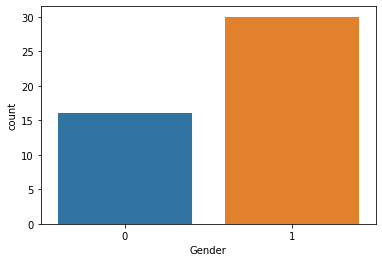

In [206]:
sns.countplot(x="Gender", data=Imbalanced_dataset_low)

In [207]:
Imbalanced_dataset_low.shape

(46, 17)

Low Surrogate dataset has 46 rows and same number of columns as in balanced dataset.

In [208]:
print('Duplicates in the dataset: ', Imbalanced_dataset_low.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [209]:
X_Imbalanced_dataset_low=Imbalanced_dataset_low.drop(columns=['Gender'])
Y_Imbalanced_dataset_low=Imbalanced_dataset_low['Gender'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving Medium Imbalance

In [210]:
F=balanced_dataset[balanced_dataset['Gender'] == 0] 
F= F.sample(replace=False,  n=10, random_state=1) #minority class female represented by 0
M=balanced_dataset[balanced_dataset['Gender'] == 1] 
M= M.sample(replace=False,  n=30, random_state=1) #majority class male represented by 1
Imbalanced_dataset_med=pd.concat([M, F])
Imbalanced_dataset_med.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other,Gender
60,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
36,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1
52,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
56,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1
55,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [211]:
M=(Imbalanced_dataset_med['Gender'].value_counts()[1])/(len(Imbalanced_dataset_med))*100
print('percentage of class Male: ',M)
F=Imbalanced_dataset_med['Gender'].value_counts()[0]/(len(Imbalanced_dataset_med))*100
print('percentage of class Female: ',F)

percentage of class Male:  75.0
percentage of class Female:  25.0


<AxesSubplot:xlabel='Gender', ylabel='count'>

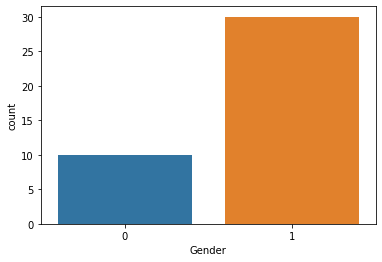

In [212]:
sns.countplot(x="Gender", data=Imbalanced_dataset_med)

In [213]:
Imbalanced_dataset_med.shape

(40, 17)

Med Surrogate dataset has 40 rows and same number of columns as in balanced dataset.

In [214]:
print('Duplicates in the dataset: ', Imbalanced_dataset_med.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [215]:
X_Imbalanced_dataset_med=Imbalanced_dataset_med.drop(columns=['Gender'])
Y_Imbalanced_dataset_med=Imbalanced_dataset_med['Gender'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving High Imbalance

In [216]:
F=balanced_dataset[balanced_dataset['Gender'] == 0] 
F= F.sample(replace=False,  n=3, random_state=1) #minority class female represented by 0
M=balanced_dataset[balanced_dataset['Gender'] == 1] 
M= M.sample(replace=False,  n=27, random_state=1) #majority class male represented by 1
Imbalanced_dataset_high=pd.concat([M, F])
Imbalanced_dataset_high.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other,Gender
60,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
36,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1
52,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
56,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1
55,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [217]:
M=(Imbalanced_dataset_high['Gender'].value_counts()[1])/(len(Imbalanced_dataset_high))*100
print('percentage of class Male: ',M)
F=Imbalanced_dataset_high['Gender'].value_counts()[0]/(len(Imbalanced_dataset_high))*100
print('percentage of class Female: ',F)

percentage of class Male:  90.0
percentage of class Female:  10.0


<AxesSubplot:xlabel='Gender', ylabel='count'>

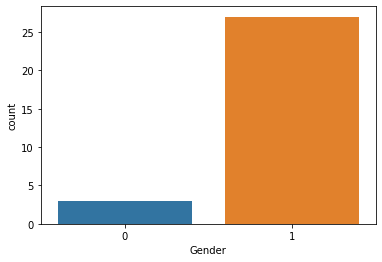

In [218]:
sns.countplot(x="Gender", data=Imbalanced_dataset_high)

In [219]:
Imbalanced_dataset_high.shape

(30, 17)

High Surrogate dataset has 30 rows and same number of columns as in balanced dataset.

In [220]:
print('Duplicates in the dataset: ', Imbalanced_dataset_high.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [221]:
X_Imbalanced_dataset_high=Imbalanced_dataset_high.drop(columns=['Gender'])
Y_Imbalanced_dataset_high=Imbalanced_dataset_high['Gender'].copy()

Features and target label are separated in the above piece of code.

# Deployment Code

# Baseline Model Implementation

Calling baseline function on balanced dataset

In [223]:
balanced_accuracy_baseline,balanced_f1_baseline,balanced_accuracies_baseline,balanced_f1_scores_baseline=base_model1(X_balanced_dataset,Y_balanced_dataset)

Mean Accuracy : 0.6 ,Standard Deviation: 0.20887344951867914
Mean F1 score : 0.5526190476190476 ,Standard Deviation: 0.2799709452045518


Calling baseline function on low imbalanced dataset

In [224]:
low_accuracy_baseline,low_f1_baseline,low_accuracies_baseline,low_f1_scores_baseline=base_model1(X_Imbalanced_dataset_low,Y_Imbalanced_dataset_low)

Mean Accuracy : 0.71 ,Standard Deviation: 0.16401219466856728
Mean F1 score : 0.7754761904761904 ,Standard Deviation: 0.13108672762232704


Calling baseline function on med imbalanced dataset

In [225]:
med_accuracy_baseline,med_f1_baseline,med_accuracies_baseline,med_f1_scores_baseline=base_model1(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

Mean Accuracy : 0.725 ,Standard Deviation: 0.17500000000000002
Mean F1 score : 0.8142857142857143 ,Standard Deviation: 0.1474961085616035


Calling baseline function on highly imbalanced dataset

In [226]:
high_accuracy_baseline,high_f1_baseline,high_accuracies_baseline,high_f1_scores_baseline=base_model1(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

Mean Accuracy : 0.75 ,Standard Deviation: 0.19364916731037085
Mean F1 score : 0.8285714285714285 ,Standard Deviation: 0.15753198573817395


# Proposed Model Implementation

calling ensembled model function on balanced dataset

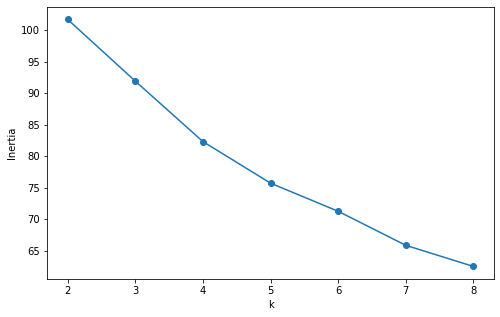

Enter the best possible value of k from elbow graph:5


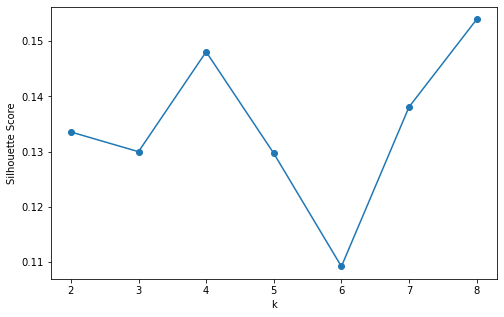

Enter the best possible value of k from silhoutte graph:8
[1 1 0 0 0 0 0]


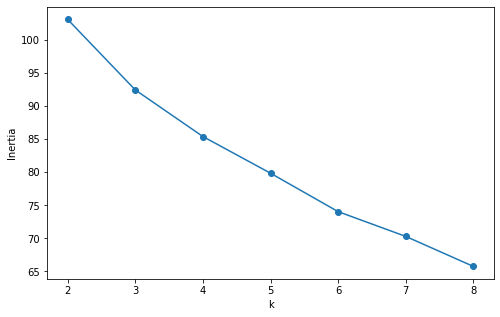

Enter the best possible value of k from elbow graph:6


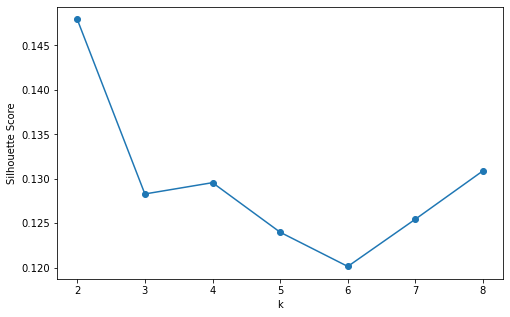

Enter the best possible value of k from silhoutte graph:2
[0 0 1 0 1 1 1]


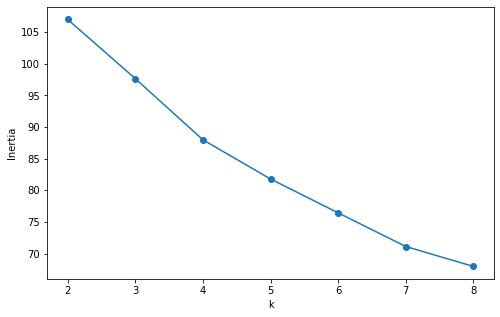

Enter the best possible value of k from elbow graph:4


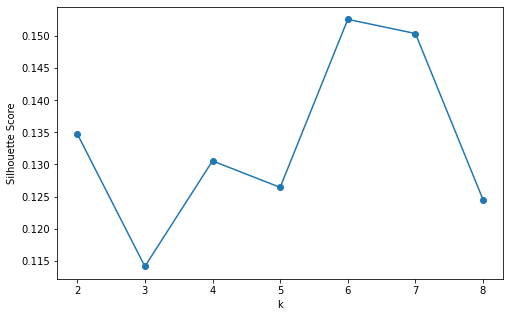

Enter the best possible value of k from silhoutte graph:6
[0 0 1 1 1 1]


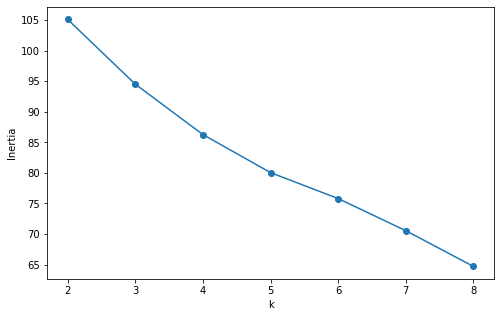

Enter the best possible value of k from elbow graph:5


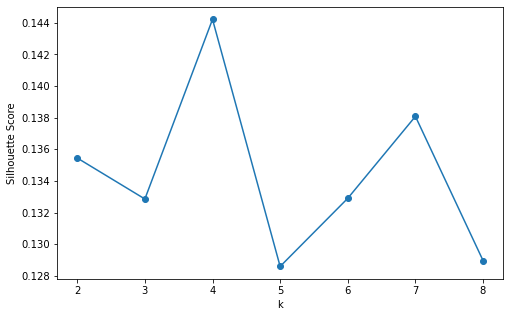

Enter the best possible value of k from silhoutte graph:4
[0 0 1 1 0 0]


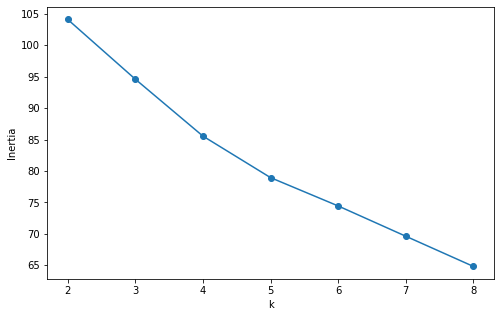

Enter the best possible value of k from elbow graph:5


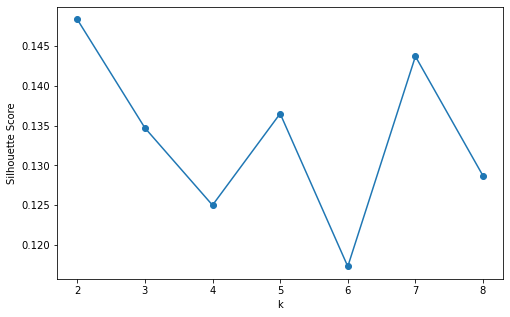

Enter the best possible value of k from silhoutte graph:2
[0 0 1 0 0 0]


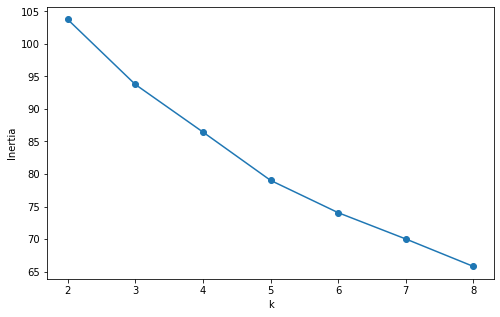

Enter the best possible value of k from elbow graph:5


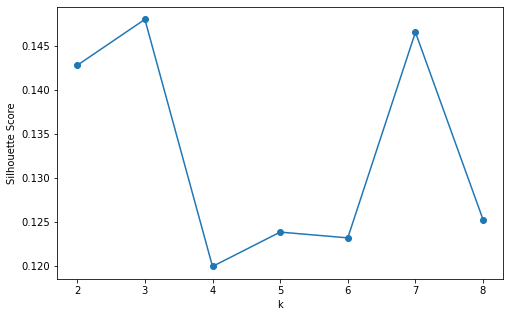

Enter the best possible value of k from silhoutte graph:3
[0 1 0 0 0 1]


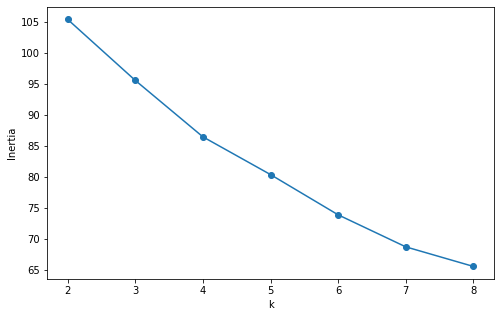

Enter the best possible value of k from elbow graph:4


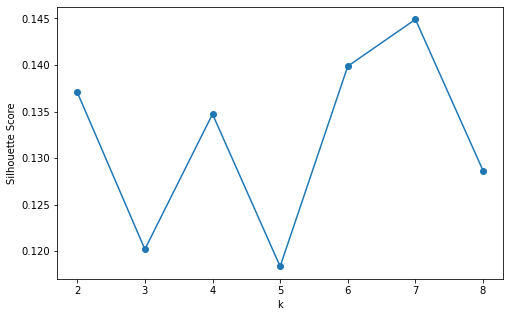

Enter the best possible value of k from silhoutte graph:7
[1 0 1 0 0 0]


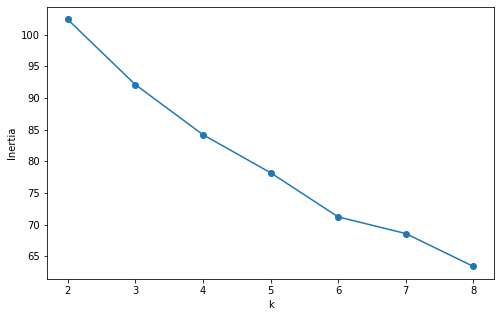

Enter the best possible value of k from elbow graph:6


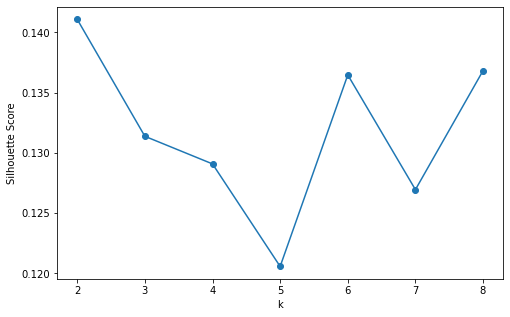

Enter the best possible value of k from silhoutte graph:2
[0 1 0 0 1 1]


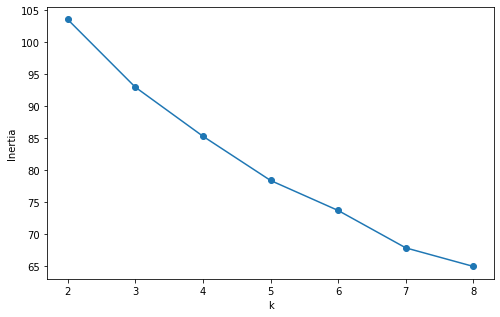

Enter the best possible value of k from elbow graph:7


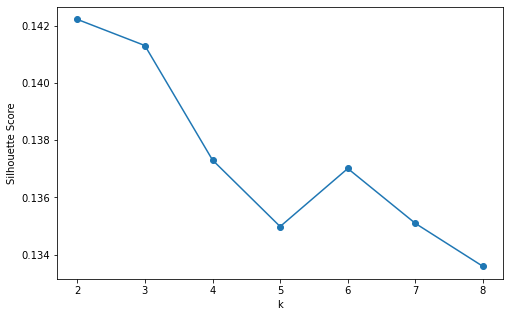

Enter the best possible value of k from silhoutte graph:2
[1 0 1 0 1 0]


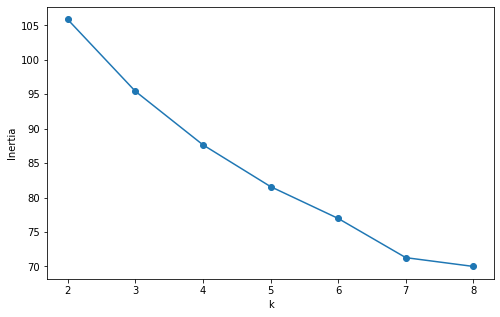

Enter the best possible value of k from elbow graph:7


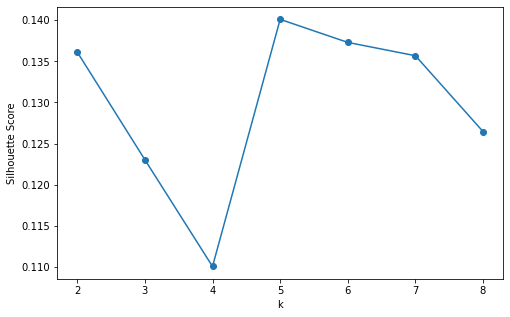

Enter the best possible value of k from silhoutte graph:5
[0 1 0 0 1 1]
Mean Accuracy : 0.5 ,Standard Deviation: 0.20619652471058064
Mean F1 score : 0.4073809523809524 ,Standard Deviation: 0.3094513651485323


In [227]:
balanced_accuracy_ensemble,balanced_f1_ensemble,balanced_accuracies_ensemble,balanced_f1_scores_ensemble=ensemble_model(X_balanced_dataset,Y_balanced_dataset)

calling ensembled model function on low imbalanced dataset

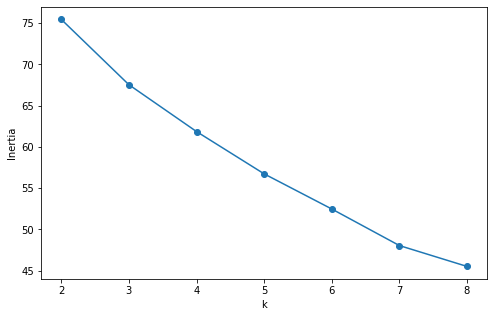

Enter the best possible value of k from elbow graph:7


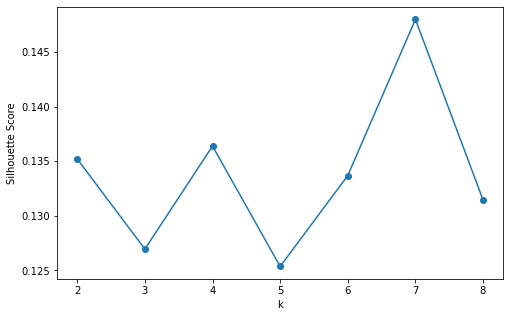

Enter the best possible value of k from silhoutte graph:7
[1 1 1 1 1]


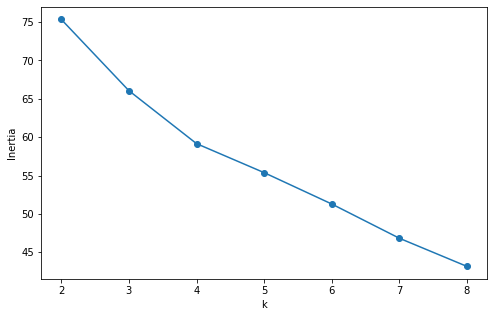

Enter the best possible value of k from elbow graph:4


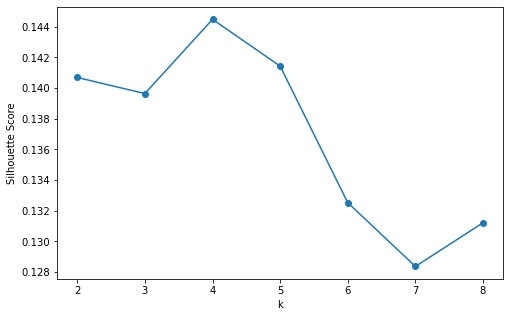

Enter the best possible value of k from silhoutte graph:4
[1 1 0 1 1]


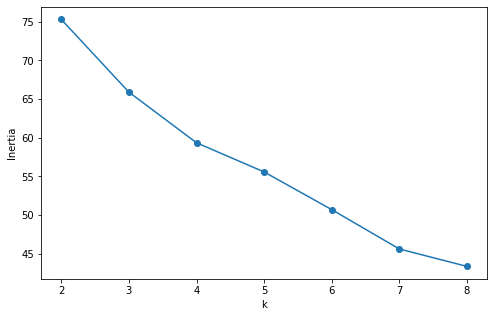

Enter the best possible value of k from elbow graph:7


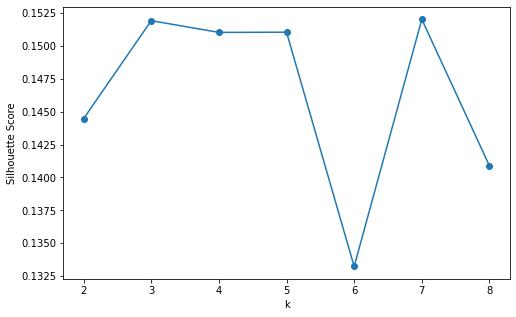

Enter the best possible value of k from silhoutte graph:7
[1 1 1 1 1]


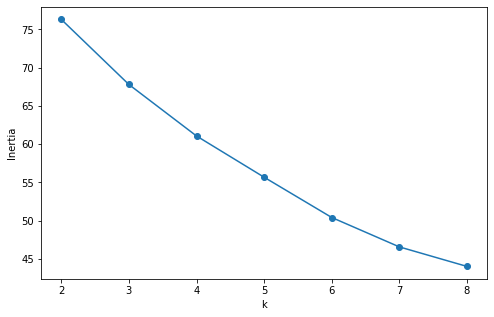

Enter the best possible value of k from elbow graph:7


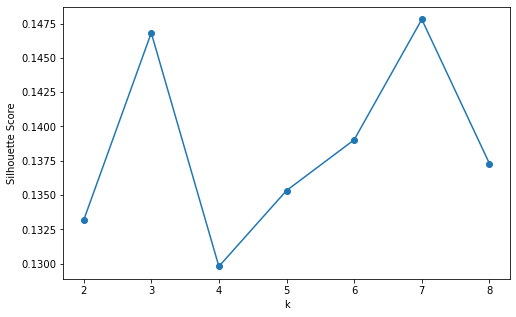

Enter the best possible value of k from silhoutte graph:7
[1 0 0 1 0]


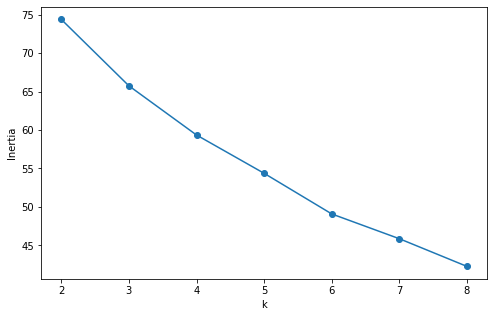

Enter the best possible value of k from elbow graph:6


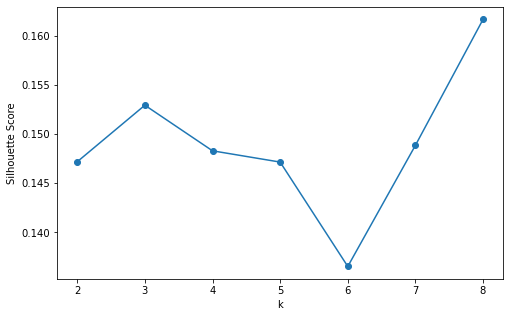

Enter the best possible value of k from silhoutte graph:8
[1 0 0 0 0]


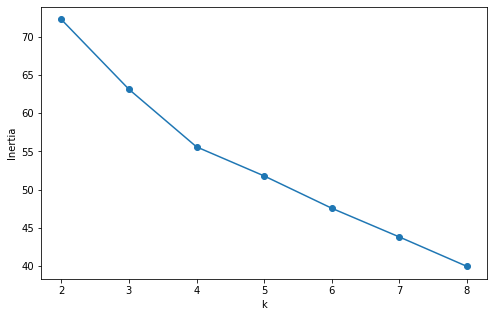

Enter the best possible value of k from elbow graph:4


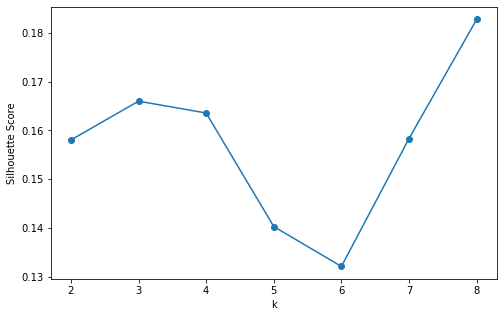

Enter the best possible value of k from silhoutte graph:8
[1 1 1 1 1]


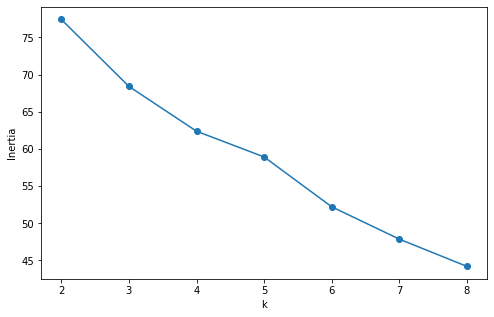

Enter the best possible value of k from elbow graph:5


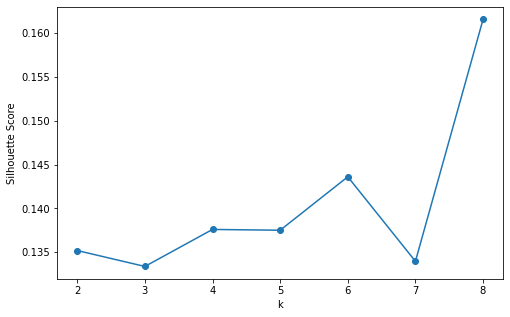

Enter the best possible value of k from silhoutte graph:8
[1 1 0 1]


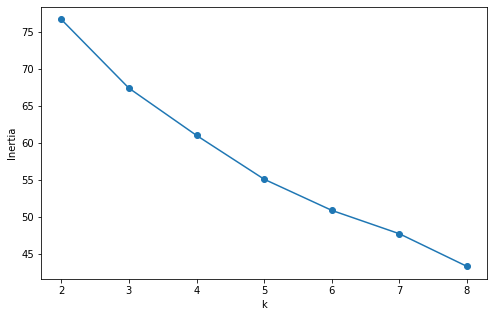

Enter the best possible value of k from elbow graph:5


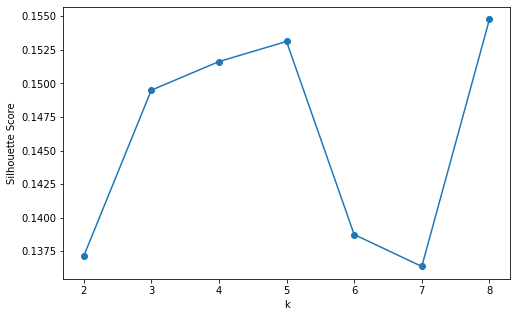

Enter the best possible value of k from silhoutte graph:8
[1 1 1 1]


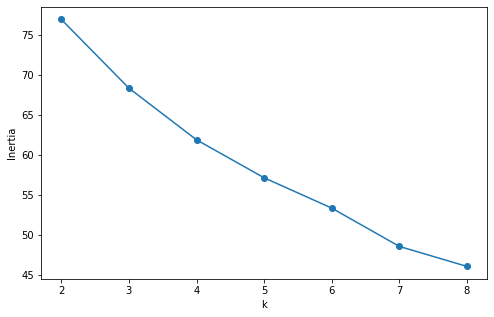

Enter the best possible value of k from elbow graph:7


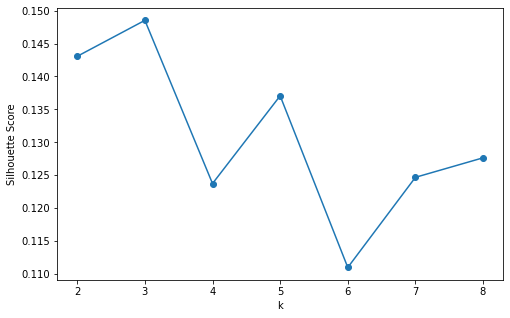

Enter the best possible value of k from silhoutte graph:3
[1 1 0 1]


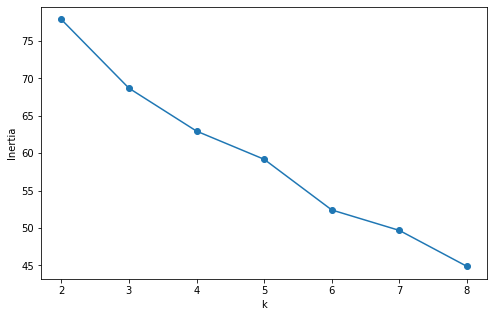

Enter the best possible value of k from elbow graph:6


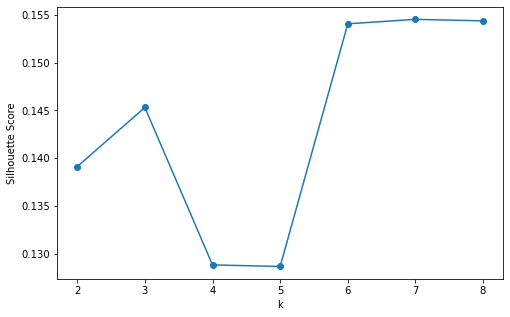

Enter the best possible value of k from silhoutte graph:7
[0 1 1 1]
Mean Accuracy : 0.545 ,Standard Deviation: 0.1011187420807834
Mean F1 score : 0.6578571428571428 ,Standard Deviation: 0.1281786327933088


In [228]:
low_accuracy_ensemble,low_f1_ensemble,low_accuracies_ensemble,low_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_low,Y_Imbalanced_dataset_low)

calling ensembled model function on med imbalanced dataset

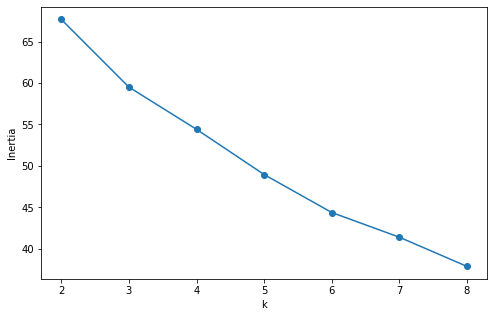

Enter the best possible value of k from elbow graph:6


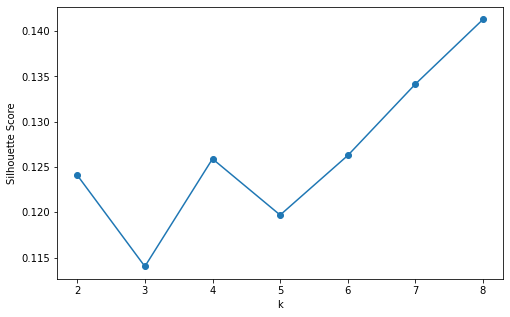

Enter the best possible value of k from silhoutte graph:8
[1 0 1 1]


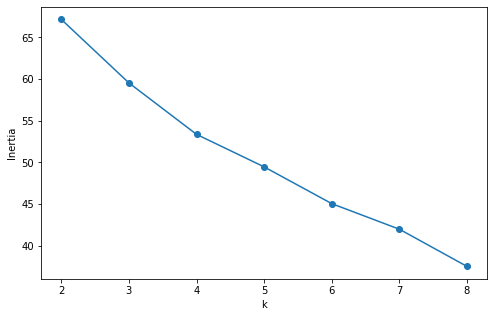

Enter the best possible value of k from elbow graph:6


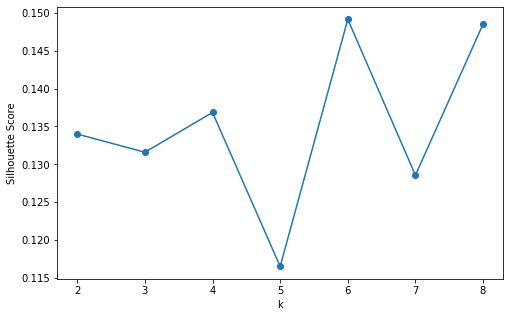

Enter the best possible value of k from silhoutte graph:6
[1 1 1 0]


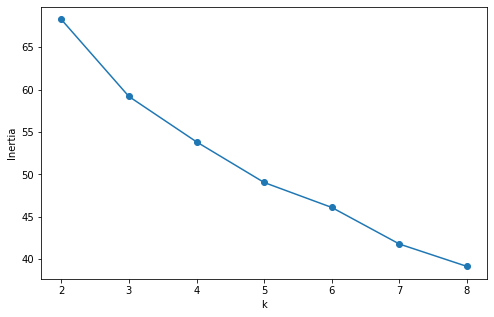

Enter the best possible value of k from elbow graph:5


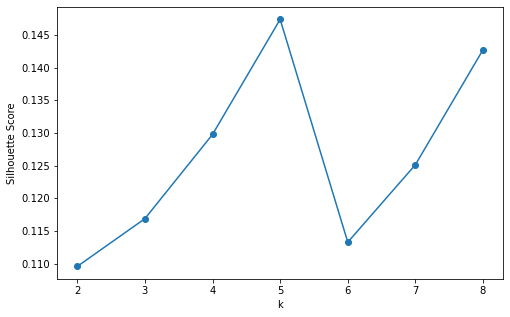

Enter the best possible value of k from silhoutte graph:5
[0 1 1 1]


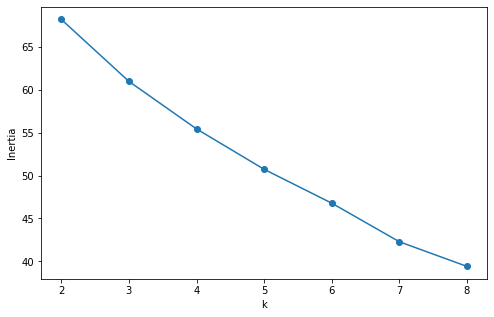

Enter the best possible value of k from elbow graph:7


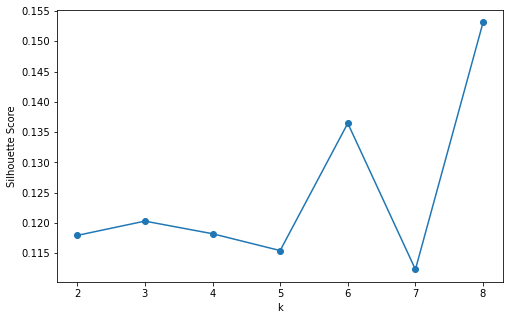

Enter the best possible value of k from silhoutte graph:8
[1 1 1 0]


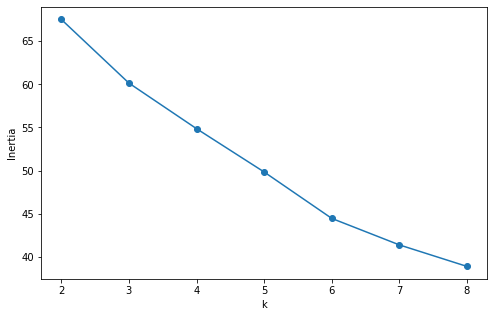

Enter the best possible value of k from elbow graph:6


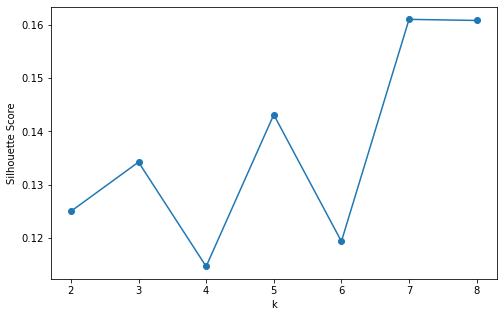

Enter the best possible value of k from silhoutte graph:7
[1 1 0 1]


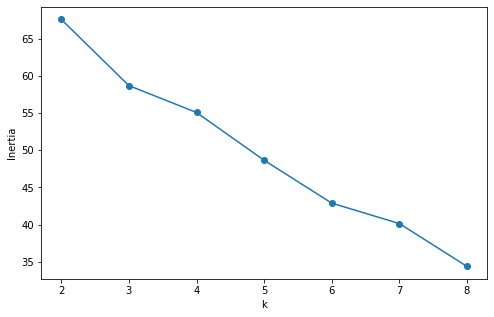

Enter the best possible value of k from elbow graph:6


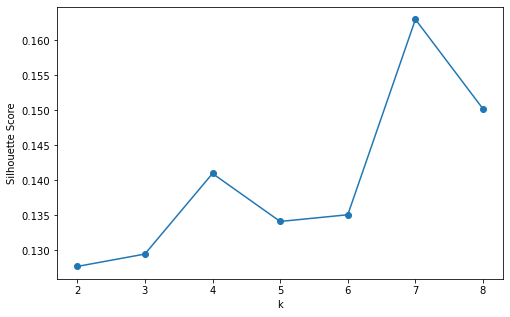

Enter the best possible value of k from silhoutte graph:7
[0 1 1 1]


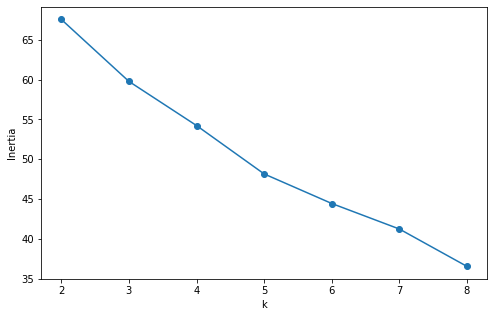

Enter the best possible value of k from elbow graph:5


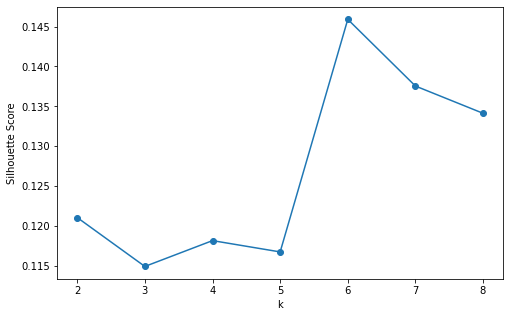

Enter the best possible value of k from silhoutte graph:6
[1 0 0 1]


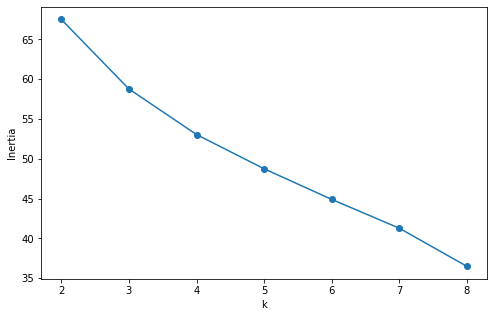

Enter the best possible value of k from elbow graph:4


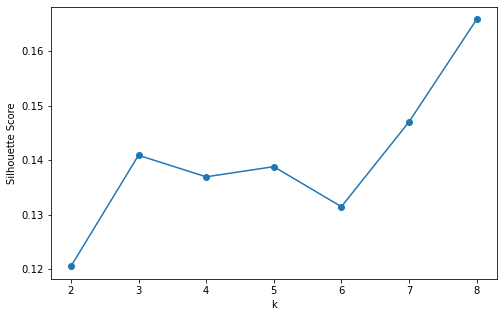

Enter the best possible value of k from silhoutte graph:8
[1 1 1 1]


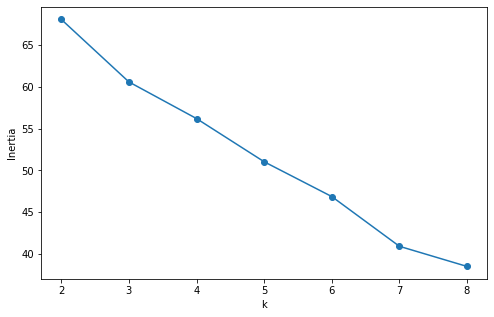

Enter the best possible value of k from elbow graph:7


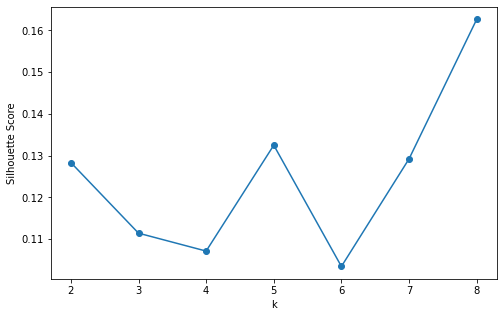

Enter the best possible value of k from silhoutte graph:8
[0 1 0 0]


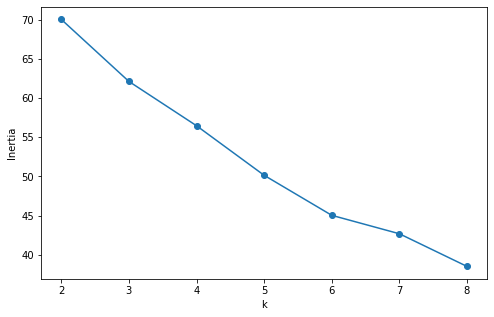

Enter the best possible value of k from elbow graph:6


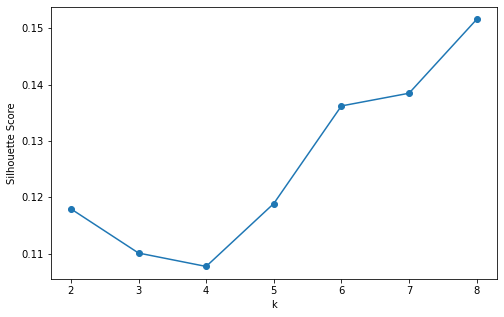

Enter the best possible value of k from silhoutte graph:8
[1 1 1 1]
Mean Accuracy : 0.625 ,Standard Deviation: 0.2304886114323222
Mean F1 score : 0.7280952380952381 ,Standard Deviation: 0.18866339748615896


In [229]:
med_accuracy_ensemble,med_f1_ensemble,med_accuracies_ensemble,med_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

calling ensembled model function on high imbalanced dataset

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


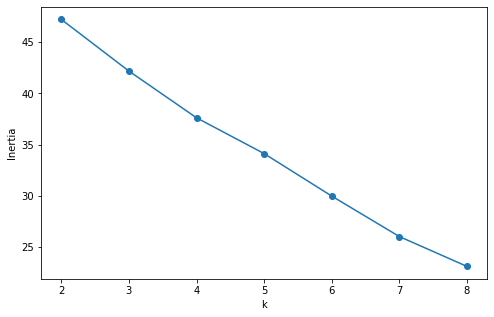

Enter the best possible value of k from elbow graph:4


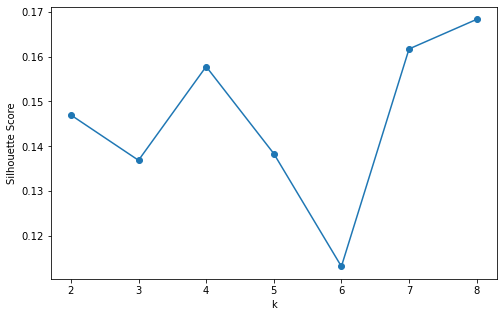

Enter the best possible value of k from silhoutte graph:8
[1 1 1]


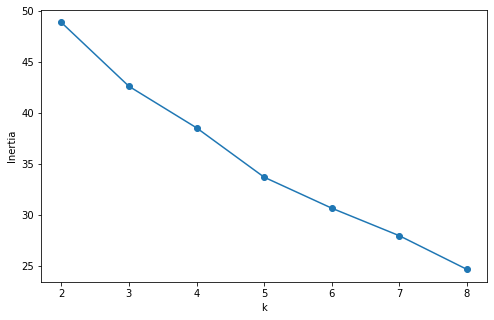

Enter the best possible value of k from elbow graph:5


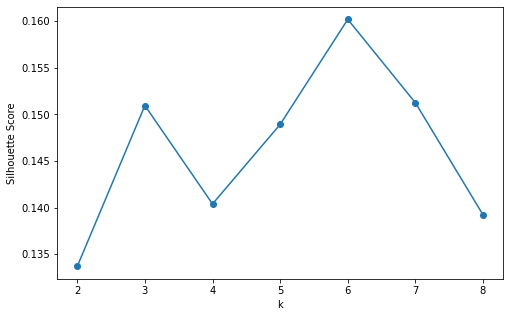

Enter the best possible value of k from silhoutte graph:6
[1 1 1]


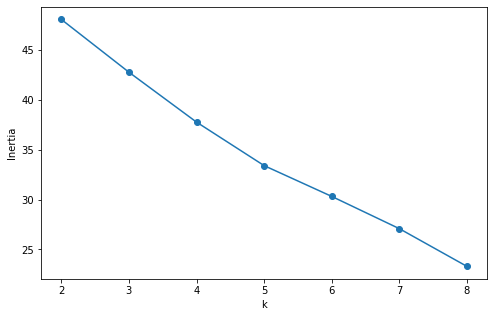

Enter the best possible value of k from elbow graph:5


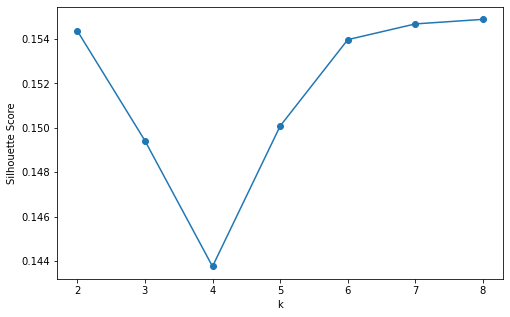

Enter the best possible value of k from silhoutte graph:8
[1 1 1]


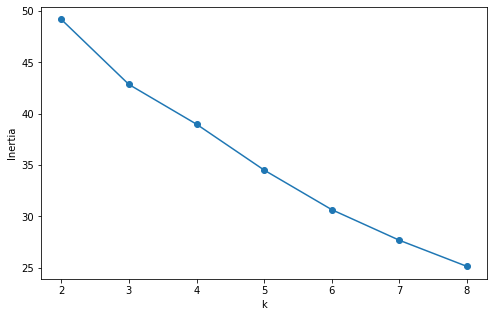

Enter the best possible value of k from elbow graph:3


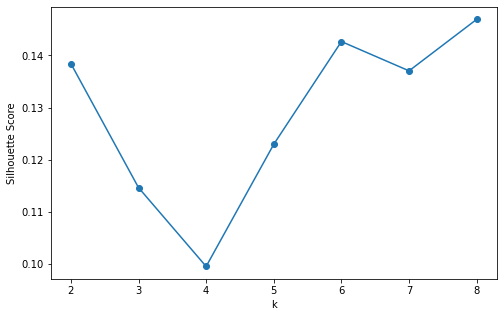

Enter the best possible value of k from silhoutte graph:8
[0 1 1]


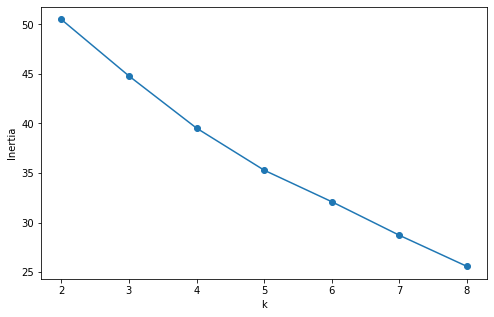

Enter the best possible value of k from elbow graph:5


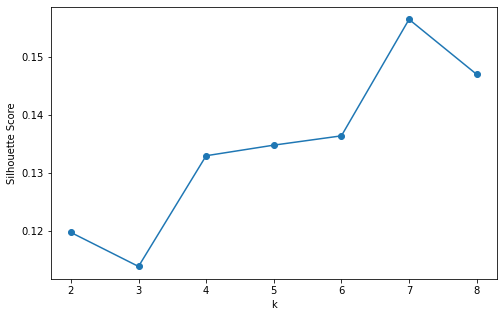

Enter the best possible value of k from silhoutte graph:7
[1 1 1]


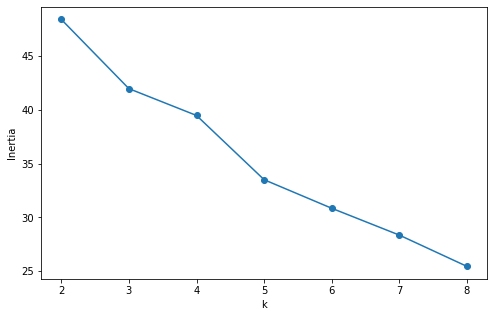

Enter the best possible value of k from elbow graph:5


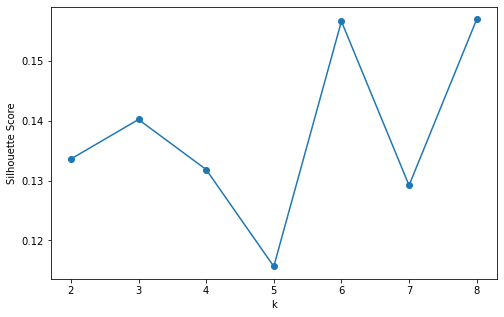

Enter the best possible value of k from silhoutte graph:6
[1 1 1]


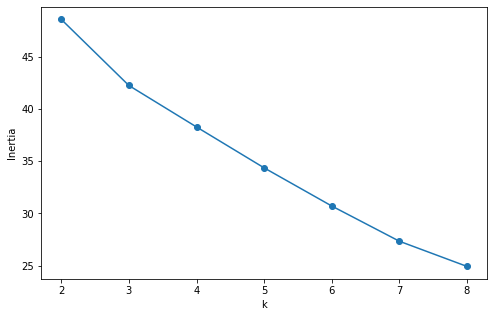

Enter the best possible value of k from elbow graph:3


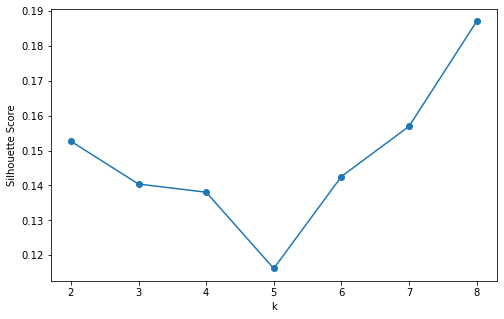

Enter the best possible value of k from silhoutte graph:8
[1 1 1]


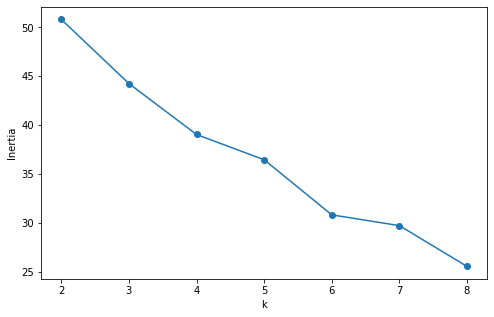

Enter the best possible value of k from elbow graph:4


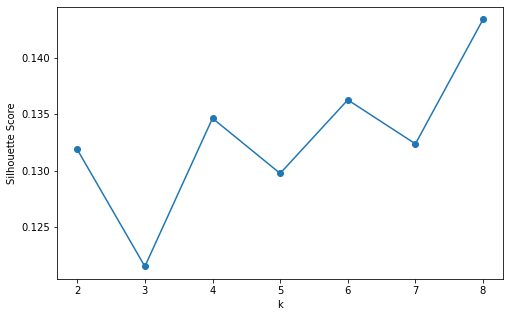

Enter the best possible value of k from silhoutte graph:8
[1 1 1]


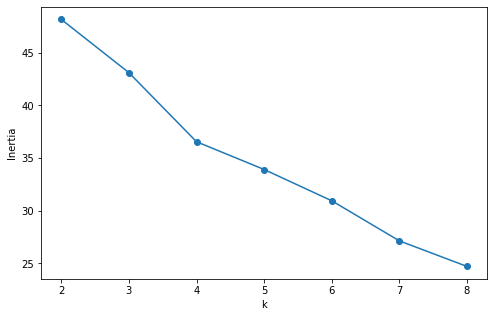

Enter the best possible value of k from elbow graph:4


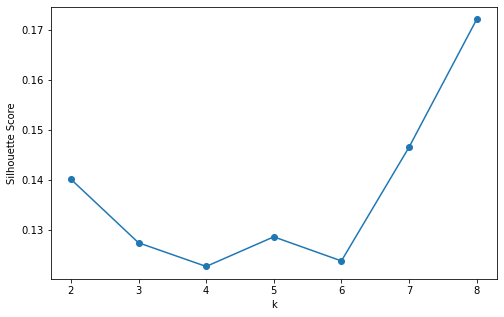

Enter the best possible value of k from silhoutte graph:8
[1 1 1]


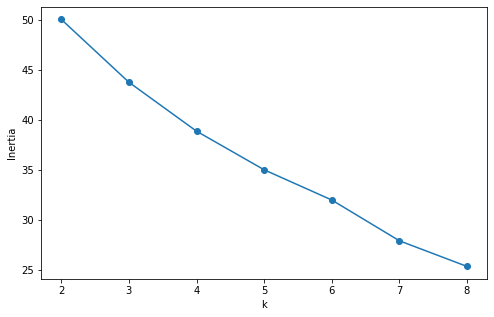

Enter the best possible value of k from elbow graph:5


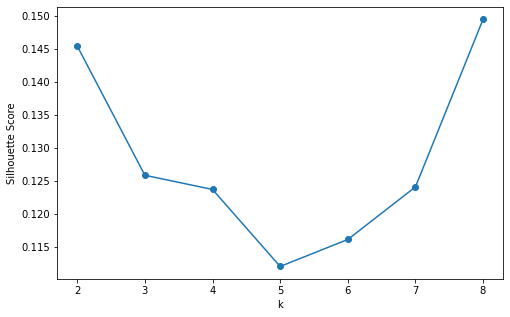

Enter the best possible value of k from silhoutte graph:8
[1 1 1]
Mean Accuracy : 0.8666666666666667 ,Standard Deviation: 0.16329931618554522
Mean F1 score : 0.92 ,Standard Deviation: 0.0979795897113271


In [230]:
high_accuracy_ensemble,high_f1_ensemble,high_accuracies_ensemble,high_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_high,Y_Imbalanced_dataset_high)

# Comparing Baseline and Proposed Method Results

# Comparison Table For Accuracies and F1 scores

In [243]:
from prettytable import PrettyTable
 
myTable = PrettyTable(["Model", "Data Imabalance", "Accuracy", "F1 Score"])
 
# Add rows
myTable.add_row(["Baseline", "Balanced", round(balanced_accuracy_baseline,2), round(balanced_f1_baseline,2)])
myTable.add_row(["Baseline", "Low Imbalanced", round(low_accuracy_baseline,2), round(low_f1_baseline,2)])
myTable.add_row(["Baseline", "Medium Imbalanced", round(med_accuracy_baseline,2),round(med_f1_baseline,2)])
myTable.add_row(["Baseline", "High Imbalanced", round(high_accuracy_baseline,2), round(high_f1_baseline,2)])
myTable.add_row(["Ensembled", "Balanced", round(balanced_accuracy_ensemble,2), round(balanced_f1_ensemble,2)])
myTable.add_row(["Ensembled", "Low Imbalanced", round(low_accuracy_ensemble,2), round(low_f1_ensemble,2)])
myTable.add_row(["Ensembled", "Medium Imbalanced", round(med_accuracy_ensemble,2), round(med_f1_ensemble,2)])
myTable.add_row(["Ensembled", "High Imbalanced", round(high_accuracy_ensemble,2), round(high_f1_ensemble,2)]) 
print(myTable)

+-----------+-------------------+----------+----------+
|   Model   |  Data Imabalance  | Accuracy | F1 Score |
+-----------+-------------------+----------+----------+
|  Baseline |      Balanced     |   0.6    |   0.55   |
|  Baseline |   Low Imbalanced  |   0.71   |   0.78   |
|  Baseline | Medium Imbalanced |   0.72   |   0.81   |
|  Baseline |  High Imbalanced  |   0.75   |   0.83   |
| Ensembled |      Balanced     |   0.5    |   0.41   |
| Ensembled |   Low Imbalanced  |   0.55   |   0.66   |
| Ensembled | Medium Imbalanced |   0.62   |   0.73   |
| Ensembled |  High Imbalanced  |   0.87   |   0.92   |
+-----------+-------------------+----------+----------+


# Permutation Tests

Permutation test for accuracies of balanced datasets for baseline and proposed models

In [244]:
bal_acc_p=permut_test(balanced_accuracies_baseline,balanced_accuracies_ensemble,balanced_accuracy_baseline,balanced_accuracy_ensemble, 70000)
print(bal_acc_p)

0.8283285714285714


Permutation test for accuracies of low imbalanced datasets for baseline and proposed models

In [245]:
low_acc_p=permut_test(low_accuracies_baseline,low_accuracies_ensemble,low_accuracy_baseline,low_accuracy_ensemble, 70000)
print(low_acc_p)

0.9885571428571429


Permutation test for accuracies of med imbalanced datasets for baseline and proposed models

In [246]:
med_acc_p=permut_test(med_accuracies_baseline,med_accuracies_ensemble,med_accuracy_baseline,med_accuracy_ensemble, 70000)
print(med_acc_p)

0.7790714285714285


Permutation test for accuracies of high imbalanced datasets for baseline and proposed models

In [247]:
high_acc_p=permut_test(high_accuracies_baseline,high_accuracies_ensemble,high_accuracy_baseline,high_accuracy_ensemble, 70000)
print(high_acc_p)

0.06744285714285714


Permutation test for f1 scores of balanced datasets for baseline and proposed models

In [248]:
bal_f1_p=permut_test(balanced_f1_scores_baseline,balanced_f1_scores_ensemble,balanced_f1_baseline,balanced_f1_ensemble, 70000)
print(bal_f1_p)

0.8467285714285714


Permutation test for f1 scores of low imbalanced datasets for baseline and proposed models

In [249]:
low_f1_p=permut_test(low_f1_scores_baseline,low_f1_scores_ensemble,low_f1_baseline,low_f1_ensemble, 70000)
print(low_f1_p)

0.9638428571428571


Permutation test for f1 scores of med imbalanced datasets for baseline and proposed models

In [250]:
med_f1_p=permut_test(med_f1_scores_baseline,med_f1_scores_ensemble,med_f1_baseline,med_f1_ensemble, 70000)
print(med_f1_p)

0.8452857142857143


Permutation test for f1 scores of high imbalanced datasets for baseline and proposed models

In [251]:
high_f1_p=permut_test(high_f1_scores_baseline,high_f1_scores_ensemble,high_f1_baseline,high_f1_ensemble, 70000)
print(high_f1_p)

0.06551428571428572


Table comparing the Permutation test values for basline and proposed models on different datasets

In [256]:
from prettytable import PrettyTable
 
myTable = PrettyTable([ "Data Imabalance", "P_value for Accuracy","P_value for F1"])
 
# Add rows
myTable.add_row(["Balanced", round(bal_acc_p,2),round(bal_f1_p,2)])
myTable.add_row([ "Low Imbalanced", round(low_acc_p,2),round (low_f1_p,2)])
myTable.add_row([ "Medium Imbalanced", round(med_acc_p,2),round( med_f1_p,2)])
myTable.add_row([ "High Imbalanced", round(high_acc_p,3), round (high_f1_p,3)]) 
print(myTable)


+-------------------+----------------------+----------------+
|  Data Imabalance  | P_value for Accuracy | P_value for F1 |
+-------------------+----------------------+----------------+
|      Balanced     |         0.83         |      0.85      |
|   Low Imbalanced  |         0.99         |      0.96      |
| Medium Imbalanced |         0.78         |      0.85      |
|  High Imbalanced  |        0.067         |     0.066      |
+-------------------+----------------------+----------------+


# Boxplots for accuracies and f1 scores

Boxplot for accuracies

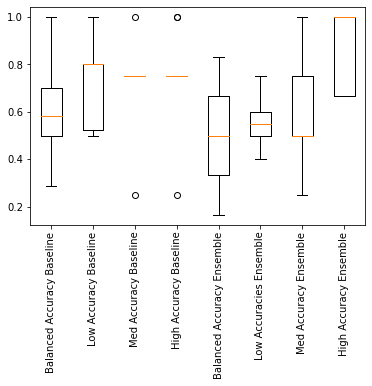

In [253]:
fig, ax = plt.subplots()
labels = ['Balanced Accuracy Baseline','Low Accuracy Baseline', 'Med Accuracy Baseline','High Accuracy Baseline','Balanced Accuracy Ensemble','Low Accuracies Ensemble','Med Accuracy Ensemble','High Accuracy Ensemble' ]
ax.boxplot([balanced_accuracies_baseline,low_accuracies_baseline, med_accuracies_baseline,high_accuracies_baseline,balanced_accuracies_ensemble,low_accuracies_ensemble,med_accuracies_ensemble,high_accuracies_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()

Boxplot for F1 scores

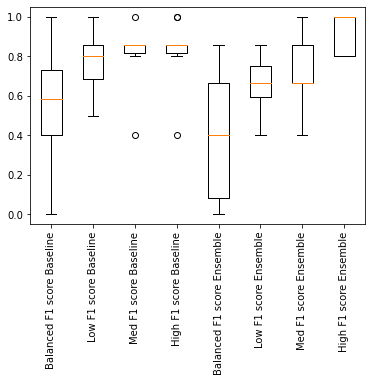

In [254]:
fig, ax = plt.subplots()
labels = ['Balanced F1 score Baseline','Low F1 score Baseline', 'Med F1 score Baseline','High F1 score Baseline','Balanced F1 score Ensemble','Low F1 score Ensemble','Med F1 score Ensemble','High F1 score Ensemble' ]
ax.boxplot([balanced_f1_scores_baseline,low_f1_scores_baseline, med_f1_scores_baseline,high_f1_scores_baseline,balanced_f1_scores_ensemble,low_f1_scores_ensemble,med_f1_scores_ensemble,high_f1_scores_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()

Boxplot for Accuracy and F1 scores

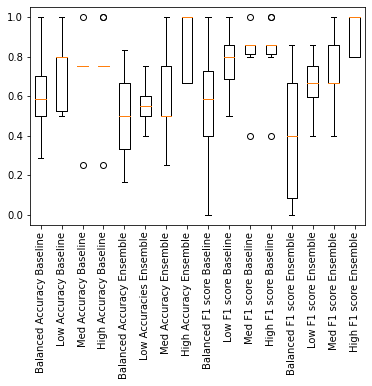

In [257]:
fig, ax = plt.subplots()
labels = ['Balanced Accuracy Baseline','Low Accuracy Baseline', 'Med Accuracy Baseline','High Accuracy Baseline','Balanced Accuracy Ensemble','Low Accuracies Ensemble','Med Accuracy Ensemble','High Accuracy Ensemble','Balanced F1 score Baseline','Low F1 score Baseline', 'Med F1 score Baseline','High F1 score Baseline','Balanced F1 score Ensemble','Low F1 score Ensemble','Med F1 score Ensemble','High F1 score Ensemble' ]
ax.boxplot([balanced_accuracies_baseline,low_accuracies_baseline, med_accuracies_baseline,high_accuracies_baseline,balanced_accuracies_ensemble,low_accuracies_ensemble,med_accuracies_ensemble,high_accuracies_ensemble,balanced_f1_scores_baseline,low_f1_scores_baseline, med_f1_scores_baseline,high_f1_scores_baseline,balanced_f1_scores_ensemble,low_f1_scores_ensemble,med_f1_scores_ensemble,high_f1_scores_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()